# Livrable final du projet - Projet Green Graph
*Equipe CesiCDP - Chef de projet : Leila | Opérateurs : Tom, Edwin*</br>
## Sommaire :
    1. Introduction

    PARTIE 1 : Modélisation
    2. Rappel de la modélisation formelle
        2.1. Résumé des hypothèses et représentations
        2.2. Justification du maintien de la modélisation
    3. Méthodes de résolution
        3.1. Choix des algorithmes
        3.2. Description des algorithmes 
        3.3. Complexité des algorithmes 

    PARTIE 2 : Implémentation et exploitation
    4. Implémentation
        4.1. Détails de l’implémentation des algorithmes
        4.2. Cas de test représentatifs
        4.3. Résultats observés sur les tests
    5. Étude expérimentale
        5.1. Méthodologie du plan d’expérience
        5.2. Analyse des performances 
        5.3. Limites observées
        5.4. Perspectives d’amélioration

    6. Plan de Travail et Organisation du Projet
        6.1. Étapes prévues 

    7. Conclusion

    8. Annexes
        8.1. Glossaire
        8.2. Références bibliographiques
        8.3. Annexes techniques 

### 1. Introduction
Dans la continuité de notre premier livrable, ce document final a pour objectif de présenter l'ensemble de la démarche menée autour du projet Green Graph, de la modélisation initiale à l'évaluation expérimentale des solutions implémentées.

Pour rappel, on se questionnait sur comment réduire l’impact environnemental des tournées de livraison tout en optimisant les coûts opérationnels.<br>
En modélisant ce problème à partir du **Problème du Voyageur de Commerce (PVC)** complété avec des contraintes réalistes :
* **Coût ou restriction de passage sur certaines arêtes :** Certaines routes peuvent être plus coûteuses ou interdites,
* **Dépendances entre visites :** Une ville ne peut être visitée qu'après en avoir visité une autre,

nous avons pu définir une approche formelle qui répond aux besoins de planification d'un trajet routier réel.

La première partie du projet consiste à modéliser mathématiquement le problème, nous y détaillons également les méthodes de résolution sélectionnées, en mettant en lumière les raisons de nos choix algorithmiques, ainsi que la complexité associée.

La seconde partie est dédiée à la mise en œuvre : l’implémentation des algorithmes, les cas de test choisis, et l’analyse des résultats obtenus. Cette étude expérimentale permet d'évaluer la performance des solutions proposées, leurs limitations, et d’ouvrir la voie à de nouvelles perspectives d’amélioration.


## Partie 1
### 2. Rappel de la modélisation formelle
##### 2.1. Résumé des hypothèses et représentations
Pour rappel, notre réseau routié est représenté sous la forme d'un graphe  non orienté $G = (V, E)$, où :
* $V = {v_0, v_1, ..., v_n}$ représente les sommets (le dépôt $v_0$ et les points de livraison),
* $E$ l’ensemble des arêtes, représentant les routes entre les sommets,
* $E_{interdit}$ l'ensemble des routes inaccessible,
* $D$ l'ensemble des dépendances entre les villes.

Chaque arête $(u, v) \in E$ est associée à un coût $c_{uv}$ (distance), une variable binaire $x_{uv} \in \{0, 1\}$ indique si l’arête $(u, v)$ est utilisée dans la tournée. Si l'arête $x_{uv} \in E_{interdit}$, alors $x_{uv}=0$.

Chaque élément $d \in D$ est une paire ordonnée $(v_i, v_j)$ signifiant le sommet $v_i$ doit être visité avant le sommet $v_j$.<br>
On note $t_i \in \mathbb{N}$, une variable qui représente l’ordre de visite du sommet $v_i$ dans la tournée, pour chaque dépendance $(v_i, v_j) \in D$ : $t_i<t_j$.

On souligne qu'on ne visite chaque sommet $V$ de $G$ exactement une fois et on retourne au point de départ $v_0$, l'objectif est de miniser le coûts total de la tournée en respectant les contraintes soit $\min \sum_{(u,v) \in E} c_{uv} \cdot x_{uv}$.


In [ ]:
def geocode_city(city_name):
    from geopy.geocoders import Nominatim
    """Converts a city name to coordinates (latitude, longitude)"""
    geolocator = Nominatim(user_agent="routing_app", timeout=10)
    location = geolocator.geocode(city_name,country_codes="FR")
    
    if location:
        return (location.latitude, location.longitude)
    else:
        return None, None

In [ ]:
def GenerateCityMapFromCSV(size):
    """Generates a list of cities from a CSV file"""
    import pandas as pd
    import random
    from tqdm import tqdm
    
    city_map = {} 
    df = pd.read_csv("CityName.csv", on_bad_lines='skip')
    city_list = df['City'].dropna().tolist()
    city_list = random.sample(city_list, size)
    for city in tqdm(city_list):
        lat, lon = geocode_city(city) 
        if  (lat or lon) is not None:
            city_map[city] = (lat,lon)
    return city_map

Cities = GenerateCityMapFromCSV(5)
print(Cities)

In [ ]:
import requests

def calculate_travel_time(departure_city, arrival_city, city_map, mode, osrm_link, params):
    """
    Calculates travel time between two cities using the OSRM API.

    Args:
        departure_city (str): Name of the departure city.
        arrival_city (str): Name of the arrival city.
        city_map (dict): Mapping of city names to coordinates (latitude, longitude).
        mode (str): Transportation mode (driving, cycling, walking).
        osrm_link (str): Base URL of the OSRM server.
        params (dict): Additional parameters for the OSRM API.

    Returns:
        tuple: (time in seconds, distance in meters, formatted time)
    """
    # Get city coordinates
    try:
        lat1, lon1 = city_map[departure_city]
        lat2, lon2 = city_map[arrival_city]
    except ValueError as e:
        return None, None, str(e)

    # Build the URL for the OSRM API
    url = f"{osrm_link}/{mode}/{lon1},{lat1};{lon2},{lat2}"

    # Call the OSRM API
    try:
        response = requests.get(url, params=params, timeout=50)
        response.raise_for_status()
    except requests.RequestException as e:
        return None, None, f"API request error: {e}"

    data = response.json()

    if data.get("code") != "Ok":
        return None, None, f"OSRM API error: {data.get('code')}"

    # Extract time and distance
    route = data["routes"][0]
    duration_seconds = route["duration"]
    distance_meters = route["distance"]

    # Format time
    hours, remainder = divmod(duration_seconds, 3600)
    minutes, _ = divmod(remainder, 60)

    formatted_time = ""
    if hours:
        formatted_time += f"{int(hours)} hour{'s' if hours > 1 else ''} "
    if minutes:
        formatted_time += f"{int(minutes)} minute{'s' if minutes > 1 else ''}"

    return duration_seconds, distance_meters, formatted_time.strip()

def display_route(departure_city, arrival_city, city_map, mode, osrm_link, params):
    """
    Displays route information between two cities.
    """
    modes = {
        "driving": "by car",
        "cycling": "by bicycle",
        "walking": "on foot"
    }

    duration, distance, message = calculate_travel_time(
        departure_city, arrival_city, city_map, mode, osrm_link, params
    )

    if duration is None:
        print(message)
        return

    print(f"Route from {departure_city} to {arrival_city} {modes.get(mode, '')}:")
    print(f"Travel time: {message}")
    print(f"Distance: {distance / 1000:.1f} km")


def matrix_generation(cities_dict, mode, link, params, toPrint=False):
    import pytz
    from datetime import datetime
    from tqdm import tqdm
    
    # Extract city names from the dictionary
    city_names = list(cities_dict.keys())
    
    # Initialiser la matrice avec des zéros
    n = len(city_names)
    matrix = [[None for _ in range(n)] for _ in range(n)]
    
    # Remplir la diagonale avec [0, 0]
    for i in range(n):
        if toPrint:
            matrix[i][i] = ["00:00:00", 0]
        else:
            matrix[i][i] = [0, 0]
    
    # Calculer uniquement la moitié supérieure de la matrice
    for i in tqdm(range(n)):
        for j in range(i+1, n):  # Commence à i+1 pour éviter la diagonale et les doublons
            sourceCity = city_names[i]
            destinationCity = city_names[j]
            
            duration, distance, _ = calculate_travel_time(sourceCity, destinationCity, cities_dict, mode, link, params)
            
            if toPrint:
                result = [datetime.fromtimestamp(duration, tz=pytz.utc).strftime('%H:%M:%S'), int(distance / 1000)]
            else:
                result = [duration, int(distance / 1000)]
            
            # Stocker le résultat à la fois dans la partie supérieure et inférieure
            matrix[i][j] = result
            matrix[j][i] = result  # Exploiter la symétrie
    
    return matrix, city_names

# Utilisation avec votre dictionnaire de villes
# Supposons que Cities est votre dictionnaire comme montré dans votre document

link = "http://router.project-osrm.org/route/v1/"
params = {
    "overview": "false",
    "alternatives": "false",
}

# Pour limiter le nombre de calculs pendant le test, vous pouvez prendre un sous-ensemble de villes
# Par exemple, les 10 premières villes
# Pour le code final, utilisez toutes les villes
# subset_cities = {k: Cities[k] for k in list(Cities.keys())[:10]}

# Générer la matrice
matrix, city_names = matrix_generation(Cities, "driving", link, params)

# Pour une version affichable
# printable_matrix, city_names = matrix_generation(Cities, "driving", link, params, True)
# from tabulate import tabulate
# print("\n\nListes [durée (s), distance (km)]\n\n" + tabulate(printable_matrix, headers=city_names, showindex=city_names, tablefmt="fancy_grid"))

In [ ]:
### Generate graph ###
def generate_complete_graph(matrix, cities):
    import networkx as nx
    import matplotlib.pyplot as plt
    
    G = nx.Graph()
    cities_converted = {}
    index = -1

    for city1 in range(len(cities)):
        for city2 in range(len(cities)):
            if city1 != city2:
                if matrix[city1][city2][1] != None:
                    if city1 not in cities_converted: 
                        index+=1
                        cities_converted[city1] = index
                    if city2 not in cities_converted:
                        index+=1
                        cities_converted[city2] = index
                    G.add_edge(cities_converted[city1], cities_converted[city2], weight=f"{matrix[city1][city2][1]}")
            
    pos = nx.spring_layout(G, seed=12, k=1.5)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray', font_size=10)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Graphe des villes avec distances")
    i = 0
    plt.text(1, -1, "\n".join([f"{i} : {city}" for i, city in enumerate(cities.keys())]), fontsize=10)
    plt.show()

def generate_hamiltonian_graph(path, path_cost, matrix, cities):
    import networkx as nx
    import matplotlib.pyplot as plt

    try :
        if path[0] != path[-1]:
            path.append(path[0])
        G = nx.DiGraph()
        cities_converted = {}
        total_weight = 0

        for city_index in range(len(path) - 1):
            city1 = list(cities.items())[path[city_index]]    
            city2 = list(cities.items())[path[city_index+1]]
            if city1 != city2:
                if city1 not in cities_converted: 
                    cities_converted[city1] = path[city_index]
                if city2 not in cities_converted:
                    cities_converted[city2] = path[city_index+1]

                edge_weight = matrix[list(cities.keys()).index(city1[0])][list(cities.keys()).index(city2[0])][1]
                total_weight += edge_weight
                G.add_edge(cities_converted[city1], cities_converted[city2],weight=f"{edge_weight}")
        
        if path_cost != total_weight:
            raise f"Dissociation between given path cost and computed total weight {path_cost, total_weight}"
        
        pos = nx.circular_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', font_size=10)
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray', width=2, alpha=0.7, arrowstyle='-|>', arrowsize=20)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        
        plt.title("Graphe du chemin à suivre entre les villes")
        plt.text(1, -1, "\n".join([f"{i} : {city}" for i, city in enumerate(cities.keys())]) + f"\n\nCoût du chemin : {path_cost}", fontsize=10)
        plt.show()
    except:
        print("error during graph creation")

def generate_complete_map(cities):
    import folium
    import webbrowser
    from collections import defaultdict
    
    french_map = folium.Map(location=[46.5, 2.5], zoom_start=6)
    loc_cities = defaultdict(list)

    for city in cities:
        lat, lon = cities[city]
        if (lat or lon) != None:
            loc_cities[city].append((lat, lon))
        else:
            cities.pop(city)

    for city in cities:
        lat, lon = loc_cities[city][0]
        folium.Marker(location=[lat, lon], popup=city).add_to(french_map)

        for destCity in cities:
            if destCity != city:
                dest_lat, dest_lon = loc_cities[destCity][0]
                folium.PolyLine([(lat, lon), (dest_lat, dest_lon)], color="blue", weight=1).add_to(french_map)
    french_map.save("graphe_complet_sur_carte.html")
    webbrowser.open("graphe_complet_sur_carte.html")

def generate_hamiltonian_map(path, cities):
    import folium
    import webbrowser
    from collections import defaultdict

    if path[0] != path[-1]:
        path.append(path[0])
    french_map = folium.Map(location=[46.5, 2.5], zoom_start=6)
    loc_cities = defaultdict(list)

    for city in cities:
        lat, lon = cities[city]
        if lat and lon:
            loc_cities[city].append((lat, lon))
        else:
            cities.pop(city)

    for i, city in enumerate(cities):
        lat, lon = loc_cities[city][0]
        folium.Marker(
            location=[lat, lon],
            popup=city,
            icon=folium.DivIcon(html=f"""<div style="font-size: 16pt; color: white; background-color: blue; border-radius: 50%; width: 24px; height: 24px; text-align: center; line-height: 24px;">{i}</div>""")
        ).add_to(french_map)

    for i in range(len(path) - 1):
        city1 = list(cities.keys())[path[i]]  
        city2 = list(cities.keys())[path[i + 1]] 
        
        lat1, lon1 = loc_cities[city1][0]
        lat2, lon2 = loc_cities[city2][0]

        folium.PolyLine([(lat1, lon1), (lat2, lon2)], color="blue", weight=2, opacity=0.6).add_to(french_map)

    french_map.save("graphe_hamiltonien_sur_carte.html")
    webbrowser.open("graphe_hamiltonien_sur_carte.html")
    
generate_complete_graph(matrix, Cities)
generate_complete_map(Cities)


##### 2.2. Justification du maintien de la modélisation
Après vérification, aucune modification n’a donc été nécessaire dans la structure mathématique pour répondre aux objectifs du projet. Nous avons décidé de conserver la structure et les représentations formelles définies dans le livrable précédent.

Cette modélisation s'est révélée suffisamment expressive pour prendre en compte l'ensemble des contraintes que nous souhaitons intégrer au problème.<br>
De plus, notre problème est basé sur le **problème du voyageur du commerce (TSP)**, bien que nous avons démontré que ce problème est difficile (NP-complet), il est applicable à d'autres problèmes de logistique.


### 3. Méthodes de résolution
##### 3.1. Choix des algorithmes
Pour répondre à notre problématique, nous devons implémenter des algorithmes qui nous permettrons de trouver le chemin le plus court passant par tout les sommets de notre graphe et qui reviendra au point de départ, soit le chemin optimale ou qui se rapproche le plus de l'optimale.

On avait premièrement prévu d'utiliser **l'algorithme A\*** et un **algorithme génétique**, mais après mûre reflexion on a décidé d'utiliser **l'algorithme Held-karp** et **un algorithme génétique**.

L'algorithme Held-karp est basé sur la programmation dynamique, explorant tout les sous-ensembles possibles des sommets. Il a été spécifiquement concue pour **TSP** et très efficace pour les petits graphes ($\le$ 20 sommets).<br>
L'algorithme A* quant à lui, est basé sur une fonction heuristique qui va d'abord explorer les chemins les plus prometteurs et effectuer une estimation du "coût restant" pour atteindre la solution à partir d’un état donné. Cet algorithme peut être adapté au TSP, mais nécessite une bonne heuristique.<br>
Finalement nous allons utilisé **l'algorithme Held-karp** car il est beaucoup plus adapté à notre problème. Il nous assure une solution garantie optimale alors que l'algorithme A* ne le fera que si l'heuristique est bien pensée. Il est aussi plus simple à implémenter or que A* nécessite un gestion de files de priorité et la sauvegarde des états des sommets visités.<br>

L'algorithme génétique qui imite l'évolution génétique pour trouver une bonne solution à un problème compliqué. Il va créer plusieurs solutions, les mélanger,  et en les mutant petit à petit jusqu’à ce qu’on obtienne un bon résultat. Cette algorithme ne garantie pas une solution optimale mais souvent très proche, il est cependant plus rapide que Held-karp et est efficace pour des graphes de taille plus importantes ($\ge$ 50-100 sommets).<br>
L'utilisation des deux algorithmes permet de combiner les avantages sur l'optimalité et la rapidité de la solution en fonction de la taille des graphes. on pourra aussi utiliser Held-karp comme référence pour évaluer la qualité des solution de l'algorithme génétique.

##### 3.2. Description des algorithmes 
##### 3.2.1. Held-Karp
L'algorithme Held-Karp ou algorithme de Bellman-Held-Kard, est un algorithme de programmation dynamique qui permet de résoudre **le problème du voyageur de commerce (TSP)**.<br>
Cette algorithme prends en entrée une matrice de distance entre chaque ville, le but est de trouver le trajet avec une distnace minimale passant par chaque ville exactement une fois avant de revenir au point de départ, il trouve la **solution exacte** à ce problème.

Dans la programmation dynamique, on divise **la tâche en sous-tâches**, pour résoudre des sous-tâches plus grandes en utilisant les résultats déjà calculés de sous-tâches plus petites, jusqu'à résoudre la tâche principale. Plutôt que de tester toutes les permutations, Held-Karp utilise la programmation dynamique pour mémoriser des sous-solutions et éviter les répétitions.<br>
On fixe une ville départ généralement 0 et une ville d'arrivée, on calcule les distances directes de la ville de départ vers toutes les autres ${2,3,\dots,n}$. Pour chaque ensemble de villes visitées (par exemple {0, 2, 3}), on garde en mémoire le meilleur coût pour atteindre la ville d'arrivée en ayant visité cet ensemble.

Dans notre contexte, on note :
* $V = {v_0, v_1, \dots, v_n}$ : ensemble des sommets, le point de départ et d'arrivé est $v_0$.
* $S$ : représente uniquement les villes intermédiaires à visiter entre le départ et le retour, $v_0$ exclus de l'ensemble c'est à dire -> $S \subseteq {v_1, v_2, ..., v_n}$ = villes à visiter avant de revenir à $v_0$.
* $c_{uv}$ : coût (distance) de l’arête $(u, v)$.
* $C(S, v_k)$ : coût minimal pour aller de $v_0$ à $v_k$, en visitant exactement les sommets de $S$. Et à la fin de l’algo, on ajoute $c_{v_k v_0}$ pour revenir au dépôt, $\min_{v_k \in S}(C(S,v_k)+c_{v_kv_0})$

##### 3.2.2. Algorithme génétique
**L'algorithme génétique (AG)** est un algorithme évolutionniste qui permet de résoudre des problèmes complexes, qui s'inspire de la notion de sélection naturelle.<br>
Dans un algorithme génétique, une population d'individus évolue au fil des générations pour s'approcher de la solution optimale en un temps raisonnable.

Le processus suit les étapes suivantes :
* **Initialisation :** Création d'une population initiale aléatoire qui sera amené à évoluer, population de chemins possibles.
* **Évaluation :** Évaluer la qualité (fitness) de chaque individu. Ici, la fitness est souvent l'inverse de la longueur totale du chemin : plus un chemin est court, meilleur il est.
* **Sélection :** Sélectionner des individus en fonction de leur fitness pour participer à la création de la prochaine génération. Les meilleurs ont plus de chances d'être choisis (sélection naturelle).
* **Croisement (crossover) :** Croiser deux individus sélectionnés pour produire un ou plusieurs descendants. Pour le TSP, des opérateurs de croisement spécifiques sont utilisés pour préserver des sous-chemins valides.
* **Mutation :** Muter certains individus pour introduire de la diversité génétique. Typiquement, cela consiste à échanger deux villes dans un chemin.
* **Remplacement :** Remplacer les anciens individus par les nouveaux pour former la nouvelle génération.
* **Arrêt :** Répéter les étapes 2 à 6 jusqu'à ce qu'un critère d'arrêt soit atteint (par exemple : nombre de générations fixé, ou amélioration insuffisante).

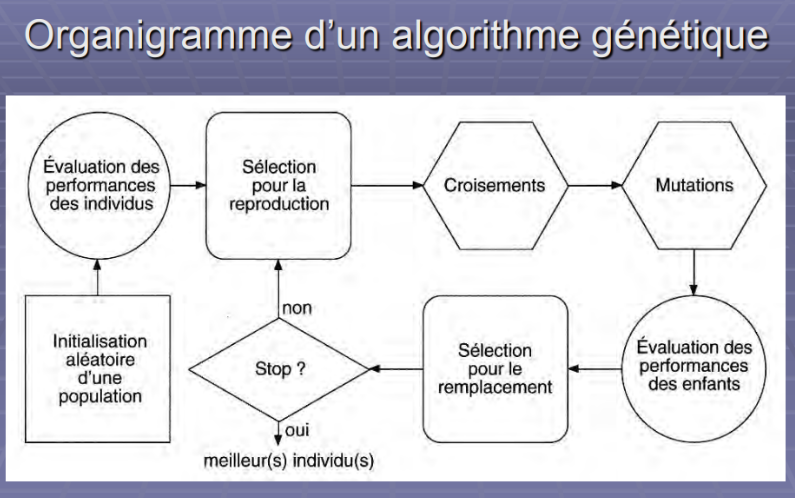

Dans notre contexte, chaque individu est une permutation des villes $v_1, v_2, ...,v_n$ (hors $v_0$, qui reste le point de départ et d’arrivée).
Le but est de trouver un ordre des villes qui minimise la distance totale, en revenant finalement à $v_0$.
Contrairement à Held-Karp qui donne la solution exacte, l'algorithme génétique fournit une solution approchée, mais de manière beaucoup plus rapide sur des graphes de grande taille.
##### 3.3. Complexité des algorithmes 
| Algorithme | Complexité temporelle | Complexité spatiale |
| ----------- | ----------- | - |
| Held-karp | $O(n^2\cdot2^n)$ | $O(n\cdot2^n)$ |
| Génétique | $O(P \times G \times n)$| $O(P \times n)$|

avec :
* $P$ = taille de la population
* $G$ = nombre de générations
* $n$ = nombre de villes

Held-Karp est plus rapide que la recherche exhaustive (n!), mais toujours exponentiel, donc limité à des graphes de taille moyenne (environ 20-25 sommets).




### 4. Implémentation
##### 4.1. Détails de l’implémentation des algorithmes
##### 4.1.1. Held-Karp

In [ ]:
import random
from pyprobs import Probability as pr
import math

MAX = 100000000  # Définition d'une constante MAX, qui représente un grand coût (route impraticable ou bloquée)

City_Dependance = [] # Matrice des dépendances entre villes

# Fonction qui va créer une matrice de dépendance entre les villes
def generate_city_dependance(cities):
    """
    Generates a city dependence matrix based on the number of cities.
    """
    city_dependance = [] # Matrice vide pour stocker la dépendance ville à ville
    for i in range(len(cities)):
        submatrix = []
        for j in range(len(cities)):
            if i == j:
                submatrix.append(0) # Pas de dépendance pour aller d'une ville à elle-même (coût 0)
            else:
                road_blocked = pr.prob(0.25)  # Avec 25% de chance la route entre deux villes sera bloquée (0)
                if road_blocked:
                    submatrix.append(0)
                else:
                    submatrix.append(1)
        city_dependance.append(submatrix)
    return city_dependance
City_Dependance = generate_city_dependance(Cities) # Génération de la matrice de dépendances pour toutes les villes existantes

# Fonction pour générer la matrice de pondération basée sur les distances/temps + risques de blocages
def generate_ponderation_matrix(matrix):
    ponderation_matrix = [] # Matrice vide pour stocker les coûts pondérés

    for i in range(len(matrix)):
        submatrix = []
        for j in range(len(matrix[i])):
            road_blocked = pr.prob(0.05)# Avec 5% de probabilité, même si dans City_Dependance une route est autorisée (1), il peut y avoir en plus un "accident" aléatoire qui bloque la route
            road_cost = random.uniform(0.6, 1.4) #  Choisis aléatoirement un nombre réel entre 0.6 et 1.4

            if road_blocked or matrix[i][j][0] == 0:
                submatrix.append(MAX)
            else:
                distance = matrix[i][j][0]
                time = matrix[i][j][1]
                cost = int(distance * 0.7) + int(time * 0.5 * road_cost) # road_cost rend certains trajets plus longs ou plus rapides de façon aléatoire
                submatrix.append(cost)

        ponderation_matrix.append(submatrix)

    return ponderation_matrix
ponderation_matrix = generate_ponderation_matrix(matrix) # Matrice de pondération basée sur la matrice de distances/temps (matrix).

def calcul_fitness(chemin, matrice_ponderation, City_Dependance):
    """
    Calcule la distance totale d'un chemin donné dans la matrice de distances.
    """
    ponderation_totale = 0
    for i in range(len(chemin) - 1):
        if matrice_ponderation[chemin[i]][chemin[i + 1]] == MAX:
            return MAX
        elif City_Dependance[chemin[i]][chemin[i + 1]] == 0:
            return MAX
        elif City_Dependance[chemin[i]][chemin[i + 1]] == 1:
            ponderation_totale += matrice_ponderation[chemin[i]][chemin[i + 1]]
    return ponderation_totale

In [ ]:
from tqdm import tqdm
import numpy as np
import datetime

def held_karp(dist, start=0):
    import itertools
    n = len(dist) # Nombre total de villes
    C = {} # Dictionnaire vide pour mémoriser les meilleurs coûts et chemins trouvés

    # Initialisation pour les paires de 2 villes (start, k)
    for k in range(n):
        if k == start:
            continue # Ignore la ville de départ
        C[(frozenset([k]), k)] = (dist[start][k], [start, k]) # Initialise le coût pour aller directement du départ à chaque ville k, stocke le coût et le chemin start -> k

    # Construction progressive des plus grands sous-ensembles
    for subset_size in tqdm(range(2, n)): # Pour chaque taille de sous-ensemble de villes (2, puis 3, 4, ..., jusqu'à n-1)
        for subset in tqdm(itertools.combinations([i for i in range(n) if i != start], subset_size)):
            S = frozenset(subset) # S est l'ensemble représentant les villes visitées dans ce sous-ensemble
            for k in subset:
                prev_subset = S - {k} # Sous-ensemble sans la ville k pour voir comment on est arrivé jusque-là
                # On initialise le meilleur coût et le meilleur chemin avec des valeurs très mauvaises pour les améliorer ensuite
                min_cost = 1000000000
                min_path = []

                for m in prev_subset: # Pour chaque ville m possible avant k
                    prev_cost, prev_path = C.get((prev_subset, m), (1000000000, []))
                    cost = prev_cost + dist[m][k]
                    
                    #Si ce nouveau chemin est meilleur on le garde en mémoire
                    if cost < min_cost:
                        min_cost = cost
                        min_path = prev_path + [k]

                C[(S, k)] = (min_cost, min_path)

    # Réinitialise les meilleures valeurs pour trouver le chemin optimal final
    full_set = frozenset([i for i in range(n) if i != start]) # Crée l'ensemble complet des villes à visiter (sans départ)
    min_cost = 1000000000
    min_path = []

    for k in range(n):
        if k == start:
            continue
        # Récupère le meilleur coût pour aller jusqu'à k en visitant toutes les villes
        cost, path = C.get((full_set, k), (1000000000, []))
        total_cost = cost + dist[k][start]
        if total_cost < min_cost:
            min_cost = total_cost
            min_path = path + [start]

    return min_cost, min_path

def adjusted_cost(i, j, dist, City_Dependance):
    base_cost = dist[i][j]
    penalty =  MAX if not City_Dependance[i][j] else 0
    return base_cost + penalty

def build_adjusted_matrix(dist, City_Dependance):
    n = len(dist)
    fitness_dist = np.zeros_like(dist)
    for i in range(n):
        for j in range(n):
            if i == j:
                fitness_dist[i][j] = 0
            else:
                fitness_dist[i][j] = adjusted_cost(i, j, dist, City_Dependance)
    return fitness_dist

adjusted_dist = build_adjusted_matrix(ponderation_matrix, City_Dependance)

start_time = datetime.datetime.now() # Démarre un chronomètre avant de lancer l'algorithme
min_cost, path = held_karp(ponderation_matrix, start=0) # Lance held_karp sur la matrice de distances ponderation_matrix
end_time = datetime.datetime.now() # Stoppe le chronomètre après l'exécution
print(f"Coût minimum : {min_cost}\nChemin : {path}\nTemps de calcul : {end_time-start_time}")
generate_hamiltonian_graph(path, min_cost, ponderation_matrix, Cities)
generate_hamiltonian_map(path, Cities)

##### 4.1.2. Algorithme génétique

In [ ]:
import numpy as np
import datetime, random

def initialiser_pheromones(n, valeur_initiale=0.1):
    return np.ones((n, n)) * valeur_initiale

def selectionner_prochaine_ville(ville_actuelle, villes_non_visitees, pheromones, matrice_poids, importance_pheromone, importance_cout
):
    if not villes_non_visitees:
        return None
    
    proba_totale = 0
    probabilites = {}
    
    for ville in villes_non_visitees:
        tau = pheromones[ville_actuelle][ville]
        attractivite = 1.0 / max(0.1, matrice_poids[ville_actuelle][ville]) # si distance faible , plus attractif
        probabilite = (tau ** importance_pheromone) * (attractivite ** importance_cout) # Formule de probabilité selon algo colonie de fourmis
        probabilites[ville] = probabilite
        proba_totale += probabilite
    
    if proba_totale == 0:
        return random.choice(villes_non_visitees)
    
    r = random.random() * proba_totale # choix selon roulette biaisé 
    cumul = 0
    
    for ville, proba in probabilites.items():
        cumul += proba
        if cumul >= r:
            return ville
    
    return villes_non_visitees[0]

def construire_solution(matrice_ponderation, pheromones, importance_pheromone, importance_cout, depart):

    n = len(matrice_ponderation)

    ville_depart = depart if depart is not None else random.randint(0, n - 1)
    
    chemin = [ville_depart]
    villes_non_visitees = list(range(len(matrice_ponderation)))
    villes_non_visitees.remove(ville_depart)
    
    ville_actuelle = ville_depart
    
    while villes_non_visitees:
        prochaine_ville = selectionner_prochaine_ville(
            ville_actuelle, 
            villes_non_visitees, 
            pheromones, 
            matrice_ponderation, 
            importance_pheromone, 
            importance_cout
        )
        
        chemin.append(prochaine_ville)
        villes_non_visitees.remove(prochaine_ville)
        ville_actuelle = prochaine_ville
    chemin.append(chemin[0])
    return chemin

def mettre_a_jour_pheromones(pheromones, chemins, fitness_values, taux_evap):
    pheromones = pheromones * (1 - taux_evap)
    
    for i, chemin in enumerate(chemins):
        fitness = fitness_values[i]
        if fitness == 0 or fitness == float('inf'):
            continue
            
        depot = 1.0 / fitness
        
        for j in range(len(chemin) - 1):
            ville_a, ville_b = chemin[j], chemin[j + 1]
            pheromones[ville_a][ville_b] += depot
            pheromones[ville_b][ville_a] += depot
        
        ville_a, ville_b = chemin[-1], chemin[0]
        pheromones[ville_a][ville_b] += depot
        pheromones[ville_b][ville_a] += depot
    
    return pheromones

def executer_aco(matrice_poids, City_Dependance, nb_fourmis=10, nb_iterations=100, 
                importance_pheromone=1.0, importance_cout=2.0, taux_evap=0.1, depart=None):
    n = len(matrice_poids)
    
    pheromones = initialiser_pheromones(n)
    
    meilleur_chemin = None
    meilleure_fitness = float('inf')
    
    for iteration in range(nb_iterations):
        chemins = []
        fitness_values = []
        
        for i in range(nb_fourmis):
            chemin = construire_solution(matrice_poids, pheromones, importance_pheromone, importance_cout, depart)
            
            fitness = calcul_fitness(chemin, matrice_poids, City_Dependance)
            
            chemins.append(chemin)
            fitness_values.append(fitness)
                        
            if fitness < meilleure_fitness:
                meilleure_fitness = fitness
                meilleur_chemin = chemin.copy()
        
        pheromones = mettre_a_jour_pheromones(pheromones, chemins, fitness_values, taux_evap)
        
        # if (iteration + 1) % 10 == 0:
        #     print(f"Itération {iteration + 1}/{nb_iterations}, Meilleure fitness: {meilleure_fitness}")
    
    return meilleur_chemin, meilleure_fitness

start_time = datetime.datetime.now()
meilleur_chemin, meilleure_fitness = executer_aco(ponderation_matrix, City_Dependance, nb_fourmis=10, nb_iterations=100, importance_pheromone=1.0, importance_cout=2.0, taux_evap=0.1, depart=0)
end_time = datetime.datetime.now()
print(f"Meilleur chemin trouvé : {meilleur_chemin}")
print(f"Meilleure fitness : {meilleure_fitness}")
print(f"En {end_time - start_time}")
generate_hamiltonian_graph(meilleur_chemin, meilleure_fitness, ponderation_matrix, Cities)
generate_hamiltonian_map(meilleur_chemin, Cities)


##### 4.2. Cas de test représentatifs
##### 4.3. Résultats observés sur les tests


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
from itertools import product

def run_experiments(matrice_poids, City_Dependance, param_ranges):
    results = []
    param_combinations = list(product(*param_ranges.values()))
    
    for params in tqdm(param_combinations):
        nb_fourmis, nb_iterations, importance_pheromone, importance_cout, taux_evap = params
        start_time = datetime.datetime.now()
        _, fitness = executer_aco(
            matrice_poids, 
            City_Dependance,
            nb_fourmis=nb_fourmis,
            nb_iterations=nb_iterations,
            importance_pheromone=importance_pheromone,
            importance_cout=importance_cout,
            taux_evap=taux_evap
        )
        end_time = datetime.datetime.now()
        duration = (end_time - start_time).total_seconds()
        
        results.append({
            'params': params,
            'fitness': fitness,
            'time': duration
        })
    
    return results

def plot_results(results, param_ranges):
    param_names = ['nb_fourmis', 'nb_iterations', 'importance_pheromone', 'importance_cout', 'taux_evap']
    
    for i, param in enumerate(param_names):
        plt.figure(figsize=(10, 6))
        x_values = [r['params'][i] for r in results]
        y_values = [r['fitness'] for r in results]
        
        unique_params = sorted(list(set(x_values)))
        avg_fitness = []
        
        for p in unique_params:
            mask = [x == p for x in x_values]
            avg_fitness.append(np.mean([y for y, m in zip(y_values, mask) if m]))
        
        plt.plot(unique_params, avg_fitness, 'o-')
        plt.xlabel(param)
        plt.ylabel('Average Fitness')
        plt.title(f'Impact of {param} on Solution Quality')
        plt.grid(True)
        i=0
        while not os.path.join(f"./benchmarks/fourmies/{param}_{i}.png"):
            i += 1
        plt.savefig(f"./benchmarks/fourmies/{param}_{i}.png")
        plt.show()

def analyze_parameters(matrice_poids, City_Dependance):
    param_ranges = {
        'nb_fourmis': [5, 10, 20, 50],
        'nb_iterations': [50, 100, 200],
        'importance_pheromone': [0.5, 1.0, 2.0],
        'importance_cout': [0.5, 1.0, 2.0],
        'taux_evap': [0.05, 0.1, 0.2]
    }
    
    results = run_experiments(matrice_poids, City_Dependance, param_ranges)
    plot_results(results, param_ranges)
    
    best_result = min(results, key=lambda x: x['fitness'])
    print("\nBest Parameters:")
    print(f"nb_fourmis: {best_result['params'][0]}")
    print(f"nb_iterations: {best_result['params'][1]}")
    print(f"importance_pheromone: {best_result['params'][2]}")
    print(f"importance_cout: {best_result['params'][3]}")
    print(f"taux_evap: {best_result['params'][4]}")
    print(f"Best Fitness: {best_result['fitness']}")
    print(f"Execution Time: {best_result['time']} seconds")

analyze_parameters(ponderation_matrix, City_Dependance)

In [ ]:
import ast
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd

df_32 = pd.read_csv("benchmarks\weighted_matrix.csv", on_bad_lines='skip')

matrice = []
with open("./benchmarks/matrice200.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:  
            line = line.replace("[", "").replace("]", "")
            items = line.split(",")
            row = []
            for item in items:
                try:
                    row.append(float(item.strip())) 
                except ValueError:
                    print(f"Erreur de conversion pour l'élément : {item}")
            matrice.append(row)


df_200 = pd.DataFrame(matrice)
print(df_200)
first_city = 0

hk_result_list = []
ants_result_list = []
hk_duration = []
ants_duration = []

City_Dependance = generate_city_dependance(df_200.columns[:185])
df_reduit = df_200.iloc[:185, :185]
ponderation_matrix = df_reduit.to_numpy()

adjusted_dist = build_adjusted_matrix(ponderation_matrix, City_Dependance)

analyze_parameters(adjusted_dist, City_Dependance)

for i in range(3, len(df_32.columns)-1):
    print(f"Start with i as {i}")
    City_Dependance = generate_city_dependance(df_32.columns[:i])
    df_reduit = df_32.iloc[:i, :i]
    ponderation_matrix = df_reduit.to_numpy()

    adjusted_dist = build_adjusted_matrix(ponderation_matrix, City_Dependance)
    if i < 23:
        start_time = datetime.datetime.now()
        min_cost, path = held_karp(adjusted_dist, start=first_city)
        end_time = datetime.datetime.now()
        hk_result_list.append(min_cost if min_cost < MAX else 0)
        hk_duration.append((end_time - start_time).total_seconds())

    start_time = datetime.datetime.now()
    ants_path, ants_result =  executer_aco(ponderation_matrix, City_Dependance, nb_fourmis=10, nb_iterations=100, importance_pheromone=1.0, importance_cout=2.0, taux_evap=0.1, depart=first_city)
    end_time = datetime.datetime.now()
    ants_result_list.append(ants_result if ants_result < MAX else 0)
    ants_duration.append((end_time - start_time).total_seconds())

    # print(f"{np.array(City_Dependance)}\nheld result :{path} - cost {min_cost} \nants result :{ants_path} - cost {ants_result}")


x = np.arange(3, 3 + len(hk_result_list))  
width = 0.35  
fig, ax = plt.subplots(figsize=(15, 6))
print(f"{hk_result_list}\n{ants_result_list}")
ax.bar(x - width/2, hk_result_list, width=width, color='skyblue', label='Held-Karp')
ax.bar(x + width/2, ants_result_list, width=width, color='red', label='Ants')

for i, val in enumerate(hk_result_list):
    ax.text(x[i] - width/2, val / 2, f"{val:.1f}", ha='center', va='center', fontsize=12, rotation=90, color='black')

for i, val in enumerate(ants_result_list):
    ax.text(x[i] + width/2, val / 2, f"{val:.1f}", ha='center', va='center', fontsize=12, rotation=90, color='white')

for i in range(len(x)):
    hk_val = hk_result_list[i]
    ants_val = ants_result_list[i]
    max_height = max(hk_val, ants_val)
    mid_x = x[i]  # au milieu du couple de barres

    # Exemple : différence absolue
    ax.text(mid_x, max_height + 1, f"Diff: {100*(ants_val/hk_val):0.1f} %" if hk_val > 0 else "", ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Nombre de villes')
ax.set_ylabel('Coût minimum')
ax.set_title('Comparaison Held-Karp vs Ants')
ax.set_xticks(x)  # Positionne les labels

mean_ants = (sum(ants_result_list) / len(ants_result_list))
mean_hk = (sum(hk_result_list) / len(hk_result_list))

label_pourcent_diff = mpatches.Patch(color='none', label=f"Moyenne des différences de held-karp à l'algorithme des fourmies : {((mean_ants/mean_hk)*100):.1f}%")

ax.legend(handles=[*ax.get_legend_handles_labels()[0], label_pourcent_diff])
ax.grid(axis='y')

ax.set_xticklabels([f"{i} villes" for i in x], rotation=90, ha='center')
plt.tight_layout()

plt.savefig("./benchmarks/bar_processing.png")
plt.show()

plt.title("Comparaison des temps de travail")
plt.xlabel("Taille de la matrice (indice)")
plt.ylabel("durée (en secondes)")

plt.plot(list(range(len(hk_duration))), hk_duration, label="Held-Karp", marker='o')
plt.plot(list(range(len(ants_duration))), ants_duration, label="Ants", marker='s')

plt.legend()
plt.grid(True)
plt.savefig("./benchmarks/plot_processing_time.png")
plt.show()


### 5. Étude expérimentale
##### 5.1. Méthodologie du plan d’expérience
##### 5.2. Analyse des performances 
##### 5.3. Limites observées
##### 5.4. Perspectives d’amélioration



### 6. Plan de Travail et Organisation du Projet
##### 6.1. Étapes prévues 


### 7. Conclusion


### 8. Annexes
##### 8.1. Glossaire
* **Programmation dynamique :** Technique de programmation visant à donner les solutions optimales à un problème P. La méthode s’applique lorsque la résolution de P peut se faire en résolvant r sous-problèmes P1, ..., Pr. 
* **Algorithme heuristique :** Méthode de résolution de problèmes qui utilise des règles pratiques ou des approximations pour trouver des solutions satisfaisantes dans un délai raisonnable, même si ces solutions ne sont pas nécessairement optimales. (exemple : algo glouton) 
* **Algorithme évolutionniste :** [Le principe s'inspire de la théorie de l'évolution pour résoudre des problèmes divers, l'idée est de faire évoluer un ensemble de solutions à un problème donné, dans l'optique de trouver les meilleurs résultats.](https://fr.wikipedia.org/wiki/Algorithme_%C3%A9volutionniste#:~:text=Les%20algorithmes%20%C3%A9volutionnistes,processus%20al%C3%A9atoires.)
* **Branch & Bound (séparation et évaluation) :** Méthode d'optimisation utilisée pour résoudre des problèmes d'optimisation combinatoire, particulièrement ceux qui nécessitent de trouver une solution optimale parmi un grand nombre de possibilités.<br>
Le principe fondamental de cet algorithme repose sur deux concepts clés :
    * *Branch (Séparation) :* Il s'agit de diviser l'espace des solutions en sous-problèmes plus petits (branches). Pour un problème d'optimisation combinatoire, cela revient souvent à construire un arbre de décision où chaque nœud représente un choix partiel.
    * *Bound (Évaluation) :* On calcule des bornes (inférieures pour un problème de minimisation, supérieures pour un problème de maximisation) pour chaque sous-problème. Ces bornes permettent d'estimer la qualité de la meilleure solution possible dans cette branche.

##### 8.2. Références bibliographiques
* [Algorithmes génétiques : Jean-Phillipe Préaux](https://www.i2m.univ-amu.fr/perso/jean-philippe.preaux/PDF/pdf_proteges/OptimisationCombinatoire/Metaheuristiques3.pdf)
* [Algorithmes génétiques : Wikipedia](https://fr.wikipedia.org/wiki/Algorithme_g%C3%A9n%C3%A9tique)
* [Algorithmes génétiques : Ionos](https://www.ionos.fr/digitalguide/sites-internet/developpement-web/genetic-algorithm/)
##### 8.3. Annexes techniques 